In [1]:
import pandas as pd
import csv
import pickle as pkl
import numpy as np
from fasttext import FastText
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime


In [2]:
model = FastText.load_model('cc.en.300.bin')

In [426]:
class Embeddings:
    def __init__(self, model) -> None:
        self.model = model
    def get_embeddings(self, words):
        return np.array([self.model.get_word_vector(i) for i in words])
    

In [427]:
tags = pkl.load(open('./tags.pkl', 'rb'))

In [428]:
embedding_class = Embeddings(model)
ems = embedding_class.get_embeddings(tags[:100])

In [429]:
anew_dataset = pd.read_csv('./warriner_raw.csv')

In [430]:
anew_dict= dict()
words = anew_dataset['term']
valence_ratings = anew_dataset['pleasure']
arousal_ratings = anew_dataset['arousal']
word_embeddings = embedding_class.get_embeddings(words)
word_embedding_dict = dict(zip(words, word_embeddings))
for i in range(len(words)):
    anew_dict[words[i]] = [valence_ratings[i], arousal_ratings[i]]

In [431]:
X = word_embeddings
Y = np.array([anew_dict[i] for i in words])

In [432]:
Y

array([[6.26, 2.41],
       [5.3 , 2.65],
       [2.84, 3.73],
       ...,
       [7.  , 5.63],
       [5.86, 5.68],
       [6.3 , 4.18]])

In [433]:
X

array([[-0.03986298,  0.00379052, -0.0127756 , ..., -0.01078152,
        -0.02300994,  0.0079215 ],
       [ 0.02610103,  0.01788571,  0.00896458, ...,  0.0547346 ,
         0.02627475,  0.02617722],
       [-0.01662364, -0.06317363,  0.10360997, ..., -0.00658366,
        -0.00859841, -0.0122865 ],
       ...,
       [ 0.01154633,  0.02386309,  0.02965424, ...,  0.02644203,
         0.09439246,  0.01073311],
       [ 0.01526884, -0.06252627,  0.06748683, ..., -0.06219679,
        -0.09277178, -0.06651503],
       [ 0.04610313,  0.01816115,  0.03932561, ..., -0.00771078,
        -0.03635433,  0.0058565 ]], dtype=float32)

In [434]:

Y = Y/10
# SCaling the data -- large loss issues. 

In [435]:
Y

array([[0.626, 0.241],
       [0.53 , 0.265],
       [0.284, 0.373],
       ...,
       [0.7  , 0.563],
       [0.586, 0.568],
       [0.63 , 0.418]])

In [436]:
X

array([[-0.03986298,  0.00379052, -0.0127756 , ..., -0.01078152,
        -0.02300994,  0.0079215 ],
       [ 0.02610103,  0.01788571,  0.00896458, ...,  0.0547346 ,
         0.02627475,  0.02617722],
       [-0.01662364, -0.06317363,  0.10360997, ..., -0.00658366,
        -0.00859841, -0.0122865 ],
       ...,
       [ 0.01154633,  0.02386309,  0.02965424, ...,  0.02644203,
         0.09439246,  0.01073311],
       [ 0.01526884, -0.06252627,  0.06748683, ..., -0.06219679,
        -0.09277178, -0.06651503],
       [ 0.04610313,  0.01816115,  0.03932561, ..., -0.00771078,
        -0.03635433,  0.0058565 ]], dtype=float32)

In [437]:
pkl.dump(X, open('X.pkl', 'wb'))
pkl.dump(Y, open('Y.pkl', 'wb'))


In [438]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [439]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
test_dataset = TensorDataset(X_test, y_test)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [440]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [441]:
device

'cpu'

In [443]:
class NetworkModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.input = nn.Linear(300, 150)
        self.linear_stack = nn.Sequential(
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(150, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(25, 10),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
        )
        self.output = nn.Linear(5, 2)

    def forward(self, x):
        x = self.input(x)
        x = self.linear_stack(x)
        x = self.output(x)
        return x



In [470]:
train = True
if(train == True):
    best_loss = 10000
    model_train = NetworkModel().to(device)
    best_model = model_train.state_dict()
    epochs = 60
    learning_rate = 16e-5
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model_train.parameters(), lr=learning_rate)
    test_loss = []
    train_loss = []
    for i in range(epochs):
        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)
            Y_pred = model_train(X.float())
            loss = loss_fn(Y_pred, Y.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss.append(loss.item())
        # Test Loss
        with torch.no_grad():
            for X, Y in test_loader:
                X, Y = X.to(device), Y.to(device)
                Y_pred = model_train(X.float())
                test_loss_fn = loss_fn(Y_pred, Y.float())
            print(f'Epoch {i}, Training Loss: {loss.item()}, Test Loss: {test_loss_fn.item()}')
            test_loss.append(test_loss_fn.item())
            if(test_loss_fn.item() < best_loss):
                best_loss = test_loss_fn.item()
                best_model = model_train.state_dict()

Epoch 0, Training Loss: 0.03965025395154953, Test Loss: 0.016283055767416954
Epoch 1, Training Loss: 0.020473076030611992, Test Loss: 0.018051644787192345
Epoch 2, Training Loss: 0.014948079362511635, Test Loss: 0.012875258922576904
Epoch 3, Training Loss: 0.020394958555698395, Test Loss: 0.01282814983278513
Epoch 4, Training Loss: 0.012756689451634884, Test Loss: 0.014629033394157887
Epoch 5, Training Loss: 0.01207746472209692, Test Loss: 0.011902880854904652
Epoch 6, Training Loss: 0.010303876362740993, Test Loss: 0.007322913967072964
Epoch 7, Training Loss: 0.009552392177283764, Test Loss: 0.008895674720406532
Epoch 8, Training Loss: 0.004179859533905983, Test Loss: 0.010986573062837124
Epoch 9, Training Loss: 0.008886546827852726, Test Loss: 0.011616934090852737
Epoch 10, Training Loss: 0.005075789522379637, Test Loss: 0.005623146891593933
Epoch 11, Training Loss: 0.01110783126205206, Test Loss: 0.00900776032358408
Epoch 12, Training Loss: 0.004896960686892271, Test Loss: 0.0082898

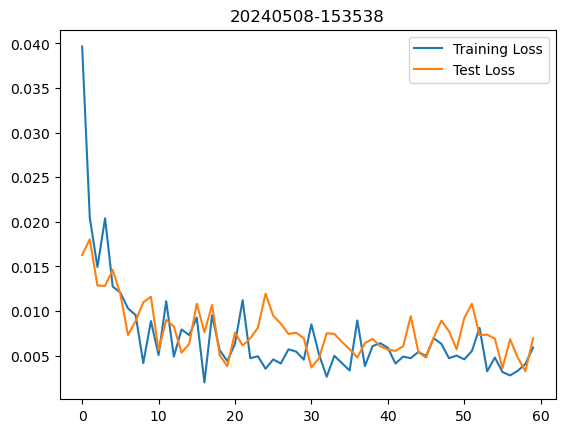

In [471]:
plt.plot(train_loss[:], label='Training Loss')
plt.plot(test_loss[:], label='Test Loss')
plt.legend()
datestring = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
plt.title(datestring)
plt.savefig(f'./train_logs/{datestring}.png')

In [483]:
array = []
for i in range(len(X_test)):
    X_out = model_train(X_test[i].float())
    # print(X_out)
    Y_out= y_test[i]
    # print(Y_out)
    array.append((sum((X_out - Y_out)**2)))
    # array.append(loss_fn(X_out, Y_out).item())

In [484]:
array.sort()

In [486]:
torch.mean(array)

TypeError: mean(): argument 'input' (position 1) must be Tensor, not list

In [487]:
array

[tensor(7.9262e-07, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(7.9129e-06, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(9.6160e-06, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(2.3958e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(2.5100e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(2.7761e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(2.7996e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(3.1430e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(3.2514e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(3.7277e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(4.0171e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(5.3096e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(5.4564e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(6.4358e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(6.4402e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(7.

In [475]:
test_loss[-1]

0.006952543277293444

In [476]:
best_loss

0.003265880746766925

In [477]:
new_model = NetworkModel()
new_model.load_state_dict(best_model)

<All keys matched successfully>

In [494]:
array = []
for i in range(len(X_test)):
    X_out = new_model(X_test[i].float())
    # print(X_out)
    Y_out= y_test[i]
    # print(Y_out)
    array.append((sum((X_out - Y_out)**2)).item())
    # array.append(loss_fn(X_out, Y_out).item())
print(sorted(array)[::-1])

[0.17393026059074954, 0.15832012463898548, 0.1435221372164106, 0.13118807665641602, 0.12046238137451759, 0.10874087224243342, 0.1031937653777054, 0.09729147154096911, 0.09506525800679769, 0.09421256003024978, 0.09224026396833815, 0.08870569884476469, 0.08855946883451067, 0.08777999246879017, 0.08700691314232428, 0.08526109917874099, 0.08492592608002267, 0.08287448853702903, 0.08268984281523434, 0.08173629913393757, 0.0806156516715289, 0.08030542833078752, 0.07998137853442033, 0.07719663917234981, 0.07660553310706562, 0.07614680081421006, 0.0748928689814706, 0.07435553437202302, 0.0743441387494701, 0.07283309644309163, 0.06796361888970465, 0.06754969030463669, 0.06626500946961783, 0.06534005400854295, 0.06504402159190611, 0.06468950980452146, 0.06451748658607906, 0.06431587209992472, 0.06413733739164912, 0.0639420295231086, 0.06370494764264548, 0.06366189663166444, 0.06352570407160514, 0.06347423959709424, 0.06324829596451362, 0.06266319649757485, 0.061737768148822196, 0.061203568395015

In [ ]:
array.sort()
array[::-1]

In [496]:
np.median(array)

0.008284977062343048

In [492]:
torch.save(best_model, f'./model_freezes/{datestring}.pth')

In [493]:
datestring

'20240508-153538'